In [1]:
# Reference : https://github.com/WegraLee/deep-learning-from-scratch
import sys, os
import numpy as np
import matplotlib.pyplot as plt

## Dataset

mnist

In [2]:
import urllib.request
import gzip
import pickle

class Dataset:
    url_base = 'http://yann.lecun.com/exdb/mnist/'
    dataset_dir = './data'
    save_file = dataset_dir + "/mnist.pkl"
    url_base = 'http://yann.lecun.com/exdb/mnist/'
    key_file = {
        'train_img':'train-images-idx3-ubyte.gz',
        'train_label':'train-labels-idx1-ubyte.gz',
        'test_img':'t10k-images-idx3-ubyte.gz',
        'test_label':'t10k-labels-idx1-ubyte.gz'
    }
    img_dim = (1, 28, 28)
    img_size = 784
    
    def _download(self, file_name):
        file_path = self.dataset_dir + "/" + file_name
        if os.path.exists(file_path):
            return

        print("Downloading " + file_name + " ... ")
        urllib.request.urlretrieve(self.url_base + file_name, file_path)
        print("Done")
    
    def download_mnist(self):
        for v in self.key_file.values():
            self._download(v)
            
    def _load_label(self, file_name):
        file_path = self.dataset_dir + "/" + file_name

        print("Converting " + file_name + " to NumPy Array ...")
        with gzip.open(file_path, 'rb') as f:
                labels = np.frombuffer(f.read(), np.uint8, offset=8)
        print("Done")

        return labels
    
    def _load_img(self, file_name):
        file_path = self.dataset_dir + "/" + file_name

        print("Converting " + file_name + " to NumPy Array ...")    
        with gzip.open(file_path, 'rb') as f:
                data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, self.img_size)
        print("Done")

        return data
    
    def _convert_numpy(self):
        dataset = {}
        dataset['train_img'] =  self._load_img(self.key_file['train_img'])
        dataset['train_label'] = self._load_label(self.key_file['train_label'])    
        dataset['test_img'] = self._load_img(self.key_file['test_img'])
        dataset['test_label'] = self._load_label(self.key_file['test_label'])

        return dataset
    
    def _change_one_hot_label(self, X):
        T = np.zeros((X.size, 10))
        for idx, row in enumerate(T):
            row[X[idx]] = 1

        return T

    def init_mnist(self):
        self.download_mnist()
        dataset = self._convert_numpy()
        print("Creating pickle file ...")
        with open(save_file, 'wb') as f:
            pickle.dump(dataset, f, -1)
        print("Done!")
        

    def load_mnist(self, normalize=True, flatten=True, one_hot_label=False):
        """MNIST 데이터셋 읽기

        Parameters
        ----------
        normalize : 이미지의 픽셀 값을 0.0~1.0 사이의 값으로 정규화할지 정한다.
        one_hot_label : 
            one_hot_label이 True면、레이블을 원-핫(one-hot) 배열로 돌려준다.
            one-hot 배열은 예를 들어 [0,0,1,0,0,0,0,0,0,0]처럼 한 원소만 1인 배열이다.
        flatten : 입력 이미지를 1차원 배열로 만들지를 정한다. 

        Returns
        -------
        (훈련 이미지, 훈련 레이블), (시험 이미지, 시험 레이블)
        """
        if not os.path.exists(self.save_file):
            self.init_mnist()

        with open(self.save_file, 'rb') as f:
            dataset = pickle.load(f)

        if normalize:
            for key in ('train_img', 'test_img'):
                dataset[key] = dataset[key].astype(np.float32)
                dataset[key] /= 255.0

        if one_hot_label:
            dataset['train_label'] = self._change_one_hot_label(dataset['train_label'])
            dataset['test_label'] = self._change_one_hot_label(dataset['test_label'])    

        if not flatten:
             for key in ('train_img', 'test_img'):
                dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

        return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])

dataset = Dataset()
(x_train, t_train), (x_test, t_test) = dataset.load_mnist(normalize=True, one_hot_label=True)

## Utils

In [3]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

## Model

In [4]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

## Training

train acc, test acc | 0.10441666666666667, 0.1028
train acc, test acc | 0.7934166666666667, 0.8003
train acc, test acc | 0.8776666666666667, 0.881
train acc, test acc | 0.89715, 0.9012
train acc, test acc | 0.9073333333333333, 0.9092
train acc, test acc | 0.9128833333333334, 0.9147
train acc, test acc | 0.91835, 0.9205
train acc, test acc | 0.9224166666666667, 0.9228
train acc, test acc | 0.9259833333333334, 0.9274
train acc, test acc | 0.92975, 0.9313
train acc, test acc | 0.9329, 0.9333
train acc, test acc | 0.9358166666666666, 0.9355
train acc, test acc | 0.9371666666666667, 0.9383
train acc, test acc | 0.9409833333333333, 0.9403
train acc, test acc | 0.94265, 0.9414
train acc, test acc | 0.9447666666666666, 0.9426
train acc, test acc | 0.9463, 0.9444


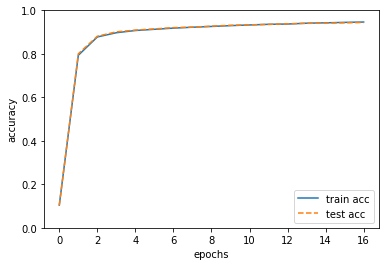

In [5]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()